In [1]:
from shapely.geometry import Point, Polygon
import numpy as np
import shapely.affinity as af
import matplotlib.pyplot as plt
from IPython.display import Video

In [2]:
shape = Polygon([[0, 0], [6, 0], [0, 3], [0, 0]]) # triangle

In [3]:
def get_circle(center=(0,0), radius=1, num_points=20):
    theta = np.linspace(0, 2*np.pi, num_points)
    points = radius * np.array([np.sin(theta),np.cos(theta)]).T
    return Polygon(points)

In [4]:
def get_rect(center=(0,0), width=15, height=1):
    rect = Polygon([[0,0],[width,0],[width,height],[0,height],[0,0]])
    rect = af.translate(rect, 
        center[0]-rect.centroid.xy[0].tolist()[0], 
        center[1]-rect.centroid.xy[1].tolist()[0])
    return rect

In [58]:
def rotate(shape, theta):
    """Rotate the shape about the origin by theta radians."""
    pts = np.array(shape.exterior.coords)
    verts = np.zeros((3, len(pts)))
    verts[2,:] = 1
    verts[0:2,:] = pts.T
    new_verts = tfmat(theta, 0.0, 0.0).dot(verts)
    return Polygon(new_verts[0:2,:].T)

def tfmat(theta, x, y):
    c = np.cos(theta)
    s = np.sin(theta)
    return np.array([
        [c, -s, x],
        [s, c, y],
        [0.0, 0.0, 1.0]
        ], dtype=float)

In [240]:
class RailPlotter():
    AXLIMS=(-10,10,-10,10)
    RECT_WIDTH=15
    RECT_HEIGHT=1
    CIRCLE_RADIUS=1
    CIRCLE_NUM_PTS=20
    
    def __init__(self, fps):
        self.fps = fps
        
        self.fig, self.ax = plt.subplots()
        self.ax.set_title('Actuated Rail')
        
        self.ax.set_xlim(RailPlotter.AXLIMS[0], RailPlotter.AXLIMS[1])
        self.ax.set_ylim(RailPlotter.AXLIMS[2], RailPlotter.AXLIMS[3])
        self.ax.set_aspect('equal')
        
        self.rect = get_rect(
            width=RailPlotter.RECT_WIDTH, 
            height=RailPlotter.RECT_HEIGHT)
        self.circ = get_circle(
            radius=RailPlotter.CIRCLE_RADIUS,
            num_points=RailPlotter.CIRCLE_NUM_PTS)
        
        self.p1, = self.ax.plot([], []) # initialize persistent artists
        self.p2, = self.ax.plot([], [])
        self.p3 = self.ax.axvline(0)
        self.artist_list = []
        
        self.previous_time = 0
        
    def update(self, time, theta, x):
        if time - self.previous_time >= 1/self.fps: # systemic rounding error :(
            self.previous_time = time
            self.plot(theta, x)
        
    def plot(self, theta, x):
        """ Plot the actuated rail. Takes 0-centered rectangle and circle.
        
        A bit of trickery going on with the matplotlib Artists here. The Artist
        objects need to be kept in memory to make a video, so I keep a persistent
        handle to the objects as self.p1 and self.p2. Then, I make sure to set the 
        old objects to be invisible in case I'm watching the output live.
        """
        new_rect = rotate(self.rect, -theta)
        new_circ = af.translate(self.circ, x, 1.5)
        new_circ = rotate(new_circ, -theta)
        
        self.p1.set_visible(False)
        self.p2.set_visible(False)
        self.p3.set_visible(False)
        
        self.p1, = self.ax.plot(*new_rect.exterior.xy, 'b')
        self.p2, = self.ax.plot(*new_circ.exterior.xy, 'r')
        self.p3 = self.ax.axvline(x)
        self.artist_list.append([self.p1, self.p2, self.p3])
        
        return self.ax
    
    def save_video(self, fname='output.mp4'):
        ani = animation.ArtistAnimation(
            self.fig, 
            self.artist_list, 
            interval=1.0/self.fps * 1000, 
            blit=True,
            repeat_delay=0)
        
        ani.save(fname, dpi=200, writer='ffmpeg')

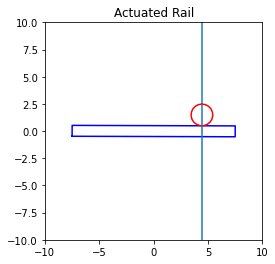

In [241]:
x = np.zeros((3,1))
dt = 0.005
g = 9.81
A = np.array([
    [1, dt, 0],
    [0, 1, dt],
    [0, 0, 0]])
B = np.array([[0],[0],[5/7*g]])

duration = 10 # length of video in seconds
num_steps = int(duration / dt) # number of simulated steps
times = np.linspace(0,duration,num_steps)

# Input function (u = sin(theta))
input_freq = 2*np.pi / 4 # 1 cycle / 4 seconds
input_amp = 0.1
us = np.sin(input_freq * times) * input_amp

rp = RailPlotter(fps=30)
for t, u in zip(times, us):
    x = A.dot(x) + B.dot(u)
    rp.update(time=t, theta=np.arcsin(u), x=x[0,0])

rp.save_video('output_sinusoid.mp4')

In [242]:
Video("output.mp4")

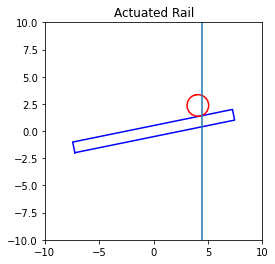

In [250]:
# Dynamics model
import time
from IPython import display
import matplotlib.animation as animation

x = np.zeros((3,1))
x_des = 1
dt = 0.005
g = 9.81
A = np.array([
    [1, dt, 0],
    [0, 1, dt],
    [0, 0, 0]])
B = np.array([[0],[0],[5/7*g]])

# Control gains
Kp=0.04
Ki=0.005
Kd=0.02

duration = 10 # length of video in seconds
num_steps = int(duration / dt) # number of simulated steps
times = np.linspace(0,duration,num_steps)

error_queue = np.zeros(int(0.5/dt)) # Two-second FIR queue
rp = RailPlotter(fps=30)
for t in times:
    
    # Error queue
    for i in range(1, len(error_queue)):
        error_queue[i-1] = error_queue[i]
    
    
    e = x[0,0] - x_des
    error_queue[-1] = e

    # Control law
    u = Kp*e + Ki*np.sum(error_queue) + Kd*(error_queue[-1] - error_queue[0])/(len(error_queue)*dt)
    u *= -1
    u = min(u, 0.2)
    u = max(u, -0.2)
#     print(u)
    # Dynamics   
    x = A.dot(x) + B.dot(u)
    rp.update(time=t, theta=np.arcsin(u), x=x[0,0])

rp.save_video('output_pid.mp4')

In [251]:
Video('output_pid.mp4')